In [ ]:
!nvidia-smi

Mon Aug 10 04:04:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/NVIDIA/apex /apex
!pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" /apex/.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive/lab/SSD/"
gdrive_dir = "/content/gdrive/My Drive/lab/SSD/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
datasets  models  test.zip  train-eval.ipynb  trainval.zip


In [ ]:
!unzip -q "/content/gdrive/My Drive/lab/SSD/trainval.zip" -d "/content"
!git clone https://github.com/ncthuan/single-shot-detection-pytorch
!cp single-shot-detection-pytorch/*.py .
!pip install albumentations==0.4.6 -q

Cloning into 'single-shot-detection-pytorch'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 71 (delta 41), reused 47 (delta 19), pack-reused 0
Unpacking objects: 100% (71/71), done.
     |████████████████████████████████| 122kB 9.5MB/s 
     |████████████████████████████████| 952kB 18.0MB/s 


In [ ]:
import os
import time
import torch
import torch.nn as nn
import torch.cuda as cuda
import seaborn as sns
from torch.utils.data import DataLoader, random_split
from dataset import VOCDataset, collate_fn
from model import SSD300, MultiBoxLoss
from utils import create_data_lists, clip_gradient, save_checkpoint, calculate_mAP

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from apex import amp

## Load dataset

In [ ]:
from utils import create_data_lists
voc07_path = os.path.join('datasets/', 'VOC2007/')
voc12_path = os.path.join('datasets/', 'VOC2012/')
create_data_lists(voc07_path, voc12_path, output_folder='datasets/')


There are 17202 training images. Files have been saved to output_folder: datasets/.

There are 4301 validation images. Files have been saved to output_folder: datasets/.


In [ ]:
!ls datasets/

label_map.json	   TRAIN_objects.json  VAL_objects.json  VOC2012
TRAIN_images.json  VAL_images.json     VOC2007


In [ ]:
torch.manual_seed(42)
trainset = VOCDataset(data_folder='datasets/', json_files=('TRAIN_images.json', 'TRAIN_objects.json'), augment=True)
valset = VOCDataset(data_folder='datasets/', json_files=('VAL_images.json', 'VAL_objects.json'))

dataloaders = dict(
    train = DataLoader(trainset, batch_size=16, collate_fn=collate_fn, shuffle=True, num_workers=2),
    val = DataLoader(valset, batch_size=64, collate_fn=collate_fn, shuffle=False, num_workers=4),
)

### EDA

In [ ]:
def visualize_objects_stat(dataset):
    targets = dataset.targets
    objects = list()
    for target in targets:
        objects.extend(target['labels'])
    print('Total number of annotated objects:', len(objects))
    sns.countplot(objects)

In [ ]:
label_map

{'aeroplane': 1,
 'bicycle': 2,
 'bird': 3,
 'boat': 4,
 'bottle': 5,
 'bus': 6,
 'car': 7,
 'cat': 8,
 'chair': 9,
 'cow': 10,
 'diningtable': 11,
 'dog': 12,
 'horse': 13,
 'motorbike': 14,
 'person': 15,
 'pottedplant': 16,
 'sheep': 17,
 'sofa': 18,
 'train': 19,
 'tvmonitor': 20,
 'background': 0}

Total number of annotated objects: 49949


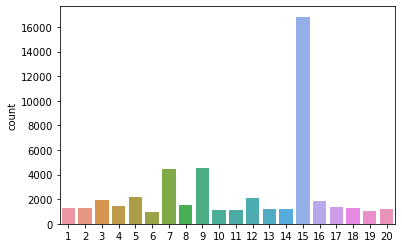

In [ ]:
visualize_objects_stat(trainset)

Total number of annotated objects: 12250


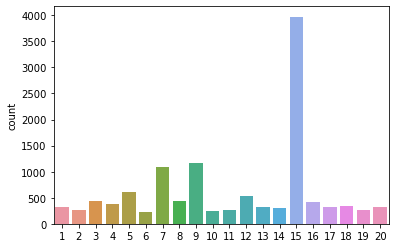

In [ ]:
visualize_objects_stat(valset)

## Train model

In [ ]:
device = torch.device("cuda" if cuda.is_available() else "cpu") 

checkpoint_path = gdrive_dir+'models/checkpoint_ssd300.pt'
checkpoint = None #torch.load('checkpoint_path')
vgg16_dir = 'models/'

# Initiate model instance
MySSD300 = SSD300(n_classes=21, vgg16_dir=vgg16_dir, checkpoint=checkpoint).to(device)

loss_func = MultiBoxLoss(priors_cxcy=MySSD300.get_prior_boxes(), threshold=0.5, neg_pos_ratio=3, alpha=1.)

optimizer = torch.optim.Adam(MySSD300.parameters(), lr=1e-3, weight_decay=5e-4)

exp_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.975, last_epoch=-1)

grad_clip = None

# Mixed precision
#MySSD300, optimizer = amp.initialize(MySSD300, optimizer, opt_level='O1')

if checkpoint:
    optimizer.load_state_dict(checkpoint['optimizer'])
    exp_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.975, last_epoch=checkpoint['epoch'])
    #amp.load_state_dict(checkpoint['amp'])

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [ ]:
def train_epoch(model, trainset_loader, loss_func, optimizer, epoch_id):
    model.train()
    train_loss = 0
    for step, (imgs, boxes, labels,_) in enumerate(trainset_loader):
        # move input data to GPU
        imgs = imgs.to(device)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]
        
        # forward
        predicted_offsets, predicted_scores = model(imgs)
        loss = loss_func(predicted_offsets, predicted_scores, boxes, labels)
        
        # backward & optimize
        optimizer.zero_grad()
        loss.backward()
        #with amp.scale_loss(loss, optimizer) as scaled_loss:
        #    scaled_loss.backward()
        optimizer.step()

        if epoch_id == 1 and step % 100 == 0:
            print(f'Epoch 1 - step {step}: train_loss: {loss.item()/trainset_loader.batch_size:.4f}')
        
        train_loss += loss.item()
        
    return train_loss/len(trainset)

def eval_epoch(model, valset_loader, loss_func):
    '''
    '''
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for step, (imgs, boxes, labels,_) in enumerate(valset_loader):
            # move input data to GPU
            imgs = imgs.to(device)
            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]
            
            predicted_offsets, predicted_scores = model(imgs)
            loss = loss_func(predicted_offsets, predicted_scores, boxes, labels)
            val_loss += loss.item()

    return val_loss/len(valset)


def train_model(model, dataloaders, optimizer, exp_lr_scheduler, loss_func, epoch=1):
    train_loss_hist, val_loss_hist = [], []
    for i in range(1,epoch+1):
        start_time = time.time()
        train_loss = train_epoch(model, dataloaders['train'], loss_func, optimizer, i)
        exp_lr_scheduler.step()
        training_time = round(time.time() - start_time)
        
        # save_checkpoint(epoch, model, optimizer) #every 3 epoch
        if i % 3 == 0:
            start_time = time.time()
            torch.save({'epoch': i, 
                        'model': model.state_dict(), 
                        'optimizer': optimizer.state_dict(), 
                        #'amp': amp.state_dict()
                       }, checkpoint_path)
            print(f'Epoch {i} - Model saved at checkpoint_path | Time consumed: {round(time.time()-start_time)}s')
        
        start_time = time.time()
        val_loss = eval_epoch(model, dataloaders['val'], loss_func)
        val_time = round(time.time() - start_time)
        
        train_loss_hist.append(train_loss)
        val_loss_hist.append(val_loss)
        
        print(f'Epoch {i} - train/val_time: {training_time}s | {val_time}s - train_loss: {train_loss:.4f} - val_loss: {val_loss:.4f}')
        
    return train_loss_hist, val_loss_hist

In [ ]:
train_loss_hist, val_loss_hist = train_model(MySSD300, dataloaders, optimizer, exp_lr_scheduler, loss_func, epoch=30)

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Epoch 1 - step 0: train_loss: 2.9408
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Epoch 1 - step 100: train_loss: 0.3721
Epoch 1 - step 200: train_loss: 0.3657
Epoch 1 - step 300: train_loss: 0.3943
Epoch 1 - step 400: train_loss: 0.3530
Epoch 1 - step 500: train_loss: 0.3488
Epoch 1 - step 600: train_loss: 0.3269
Epoch 1 - step 700: train_loss: 0.3676
Epoch 1 - step 800: train_loss: 0.3516
Epoch 1 - step 900: train_loss: 0.3488
Epoch 1 - step 1000: train_loss: 0.3194


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:114: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch 1 - train/val_time: 620s | 47s - train_loss: 0.3729 - val_loss: 0.0856
Epoch 2 - train/val_time: 599s | 46s - train_loss: 0.3356 - val_loss: 0.0841
Epoch 3 - Model saved at checkpoint_path | Time consumed: 1s
Epoch 3 - train/val_time: 604s | 46s - train_loss: 0.3235 - val_loss: 0.0810
Epoch 4 - train/val_time: 597s | 46s - train_loss: 0.3119 - val_loss: 0.0789
Epoch 5 - train/val_time: 595s | 45s - train_loss: 0.3020 - val_loss: 0.0740
Epoch 6 - Model saved at checkpoint_path | Time consumed: 1s
Epoch 6 - train/val_time: 592s | 46s - train_loss: 0.2937 - val_loss: 0.0731
Epoch 7 - train/val_time: 621s | 49s - train_loss: 0.2863 - val_loss: 0.0728
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Epoch 8 - train/val_time: 657s | 49s - train_loss: 0.2809 - val_loss: 0.0723
Epoch 9 - Model saved at checkpoint_path | Time consumed: 2s
Epoch 9 - train/val_time: 658s | 50s - tr

## Evaluate

In [ ]:
def eval_epoch(model, valset_loader, loss_func):
    '''
    '''
    model.eval()
    val_loss = 0
    
    detected_boxes = list()
    detected_labels = list()
    detected_scores = list()
    true_boxes = list()
    true_labels = list()
    true_diffs = list()
    
    with torch.no_grad():
        for step, (imgs, boxes, labels, diffs) in enumerate(valset_loader):
            # move input data to GPU
            imgs = imgs.to(device)
            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]
            diffs = [d.to(device) for d in diffs]

            # detect objects
            predicted_offsets, predicted_scores = model(imgs)
            batch_det_boxes, batch_det_labels, batch_det_scores = model.detect_objects(predicted_offsets, predicted_scores,
                                                                                       score_threshold=0.01, iou_threshold=0.5)
            # calculate val loss
            loss = loss_func(predicted_offsets, predicted_scores, boxes, labels)
            val_loss += loss.item()

            detected_boxes.extend(batch_det_boxes)
            detected_labels.extend(batch_det_labels)
            detected_scores.extend(batch_det_scores)
            true_boxes.extend(boxes)
            true_labels.extend(labels)
            true_diffs.extend(diffs)

        # calculate metrics value
        APs, mAP = calculate_mAP(detected_boxes, detected_labels, detected_scores, true_boxes, true_labels, true_diffs)
        val_loss = val_loss/len(valset)
    
    return val_loss, APs, mAP

In [ ]:
def eval_model_performance(model, valset_loader):
    ''' This take into account all objects, including difficult ones
    '''
    model.eval()
    detected_boxes = list()
    detected_labels = list()
    detected_scores = list()
    true_boxes = list()
    true_labels = list()
    #true_diffs = list()
    
    start_time = time.time()
    with torch.no_grad():
        for step, (imgs, boxes, labels, diffs) in enumerate(valset_loader):
            # move input data to GPU
            imgs = imgs.to(device)
            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]
            #diffs = [d.to(device) for d in diffs]

            # detect objects
            predicted_offsets, predicted_scores = model(imgs)
            batch_det_boxes, batch_det_labels, batch_det_scores = model.detect_objects(predicted_offsets, predicted_scores,
                                                                                       score_threshold=0.01, iou_threshold=0.5)
            detected_boxes.extend(batch_det_boxes)
            detected_labels.extend(batch_det_labels)
            detected_scores.extend(batch_det_scores)
            true_boxes.extend(boxes)
            true_labels.extend(labels)
            #true_diffs.extend(diffs)

        # calculate metrics value
        APs, mAP = calculate_mAP(detected_boxes, detected_labels, detected_scores, true_boxes, true_labels)
    
    return APs, mAP

In [ ]:
APs, mAP = eval_model_performance(MySSD300, dataloaders['val'])

In [ ]:
APs

{'aeroplane': 0.3414236009120941,
 'bicycle': 0.09090909361839294,
 'bird': 0.09090909361839294,
 'boat': 0.09090909361839294,
 'bottle': 0.0,
 'bus': 0.3882625997066498,
 'car': 0.32834258675575256,
 'cat': 0.29180702567100525,
 'chair': 0.04545454680919647,
 'cow': 0.04545454680919647,
 'diningtable': 0.07070707529783249,
 'dog': 0.24327227473258972,
 'horse': 0.234884575009346,
 'motorbike': 0.30315008759498596,
 'person': 0.24644705653190613,
 'pottedplant': 0.0,
 'sheep': 0.09090909361839294,
 'sofa': 0.09090909361839294,
 'train': 0.14462809264659882,
 'tvmonitor': 0.09090909361839294}

In [ ]:
mAP

0.16146442294120789